In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model, standardize_dataset
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, MLP
from dev_losses import cauchy, rbf, gaussian_kernel, CustomSupCon, CustomContrastiveLoss
from losses import KernelizedSupCon

In [2]:
!pwd

/gpfs3/well/margulies/users/cpy397/contrastive-learning


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim_feat, hidden_dim_feat, output_dim, dropout_rate):
        super(MLP, self).__init__()
        
        self.feat_mlp = nn.Sequential(
            nn.Linear(input_dim_feat, hidden_dim_feat),
            nn.BatchNorm1d(hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim)
        )
        # Xavier initialization
        self.init_weights(self.feat_mlp)

#         self.target_mlp = nn.Linear(input_dim_target, output_dim)
#         self.init_weights(self.target_mlp)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x):
        features = self.feat_mlp(x)
        features = nn.functional.normalize(features, p=2, dim=1)
        return features

In [5]:
class MatData(Dataset):
    def __init__(self, path_feat, path_targets, target_name):
        self.matrices = np.load(path_feat)
        self.target = pd.read_csv(path_targets)[target_name].values
    def __len__(self):
        return len(self.matrices)
    def __getitem__(self, idx):
        matrix = self.matrices[idx]
        target = self.target[idx]
        matrix = torch.from_numpy(matrix).float()
        target = torch.tensor(target, dtype=torch.float32)
        return matrix, target

In [6]:
def standardize_dataset(dataset):
    # Flatten the dataset across subjects and views to simplify standardization across features
    all_features_flat = torch.cat([dataset[i][0].view(-1, dataset[i][0].shape[-1]) for i in range(len(dataset))], dim=0)
    all_targets = torch.cat([dataset[i][1].unsqueeze(0) for i in range(len(dataset))], dim=0)
    
    # Calculate mean and std dev for each feature across all subjects and views
    features_mean = all_features_flat.mean(dim=0)
    features_std = all_features_flat.std(dim=0)
    
    # Ensure no division by zero
    features_std[features_std == 0] = 1
    
    # Initialize containers for standardized features
    standardized_features_list = []
    
    # Apply standardization to each sample
    for i in range(len(dataset)):
        features = dataset[i][0].view(-1, dataset[i][0].shape[-1])  # Flatten views for standardization
        standardized_features = (features - features_mean) / features_std
        standardized_features_list.append(standardized_features.view(dataset[i][0].shape))
    
    standardized_features = torch.stack(standardized_features_list)
    
    standardized_dataset = TensorDataset(standardized_features, all_targets)
    
    return standardized_dataset

In [7]:
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str, temperature: float=0.07, contrast_mode: str='all',
                 base_temperature: float=0.07, krnl_sigma: float = 1., kernel: callable=None, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.krnl_sigma = krnl_sigma
        self.delta_reduction = delta_reduction

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction})'

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        n_views = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, krnl_sigma = self.krnl_sigma)
            
        view_count = features.shape[1]
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            features = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            features = features
            anchor_count = view_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, view_count)

        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*n_views, device=device).view(-1, 1),
            0
        )

        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T),
            self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal 

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
    
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))


        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()

In [8]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi))

def gaussian_kernel_original(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi)*krnl_sigma)

def cauchy(x, krnl_sigma):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

In [9]:
dataset = MatData("vectorized_matrices.npy", "participants.csv", "age")

In [10]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size = 0.2, random_state=42) #train_size = 5
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [11]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
input_dim_target = 1
# the rest is arbitrary
hidden_dim_feat = 1000
hidden_dim_target = 5
output_dim = 2

num_epochs = 100

lr = 0.001 # too low values return nan loss
kernel = cauchy
batch_size = 30 # too low values return nan loss
dropout_rate = 0
weight_decay = 0

In [12]:
standardized_train_dataset = standardize_dataset(train_dataset)
std_train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)

standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [15]:
torch.cuda.empty_cache()
model = MLP(input_dim_feat, hidden_dim_feat, output_dim, dropout_rate = dropout_rate).to(device)
criterion_pft = KernelizedSupCon(method='expw', temperature=0.03, base_temperature=0.03, kernel=kernel, krnl_sigma = 1)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        out_feat = model(features)
        loss = criterion_pft(out_feat.unsqueeze(1), targets)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')



Epoch 0 | Mean Loss 24.83685592651367
Epoch 1 | Mean Loss 4.987674903869629
Epoch 2 | Mean Loss 3.542593059539795
Epoch 3 | Mean Loss 3.4528326892852785
Epoch 4 | Mean Loss 3.4118474292755128
Epoch 5 | Mean Loss 3.3966243743896483
Epoch 6 | Mean Loss 3.389916667938232
Epoch 7 | Mean Loss 3.387353639602661
Epoch 8 | Mean Loss 3.3862805652618406
Epoch 9 | Mean Loss 3.3777949810028076
Epoch 10 | Mean Loss 3.3772931575775145
Epoch 11 | Mean Loss 3.3767873859405517
Epoch 12 | Mean Loss 3.3715629291534426
Epoch 13 | Mean Loss 3.371151876449585
Epoch 14 | Mean Loss 3.3692108821868896
Epoch 15 | Mean Loss 3.370836172103882
Epoch 16 | Mean Loss 3.3661710166931154
Epoch 17 | Mean Loss 3.367881259918213
Epoch 18 | Mean Loss 3.3677408599853518
Epoch 19 | Mean Loss 3.366333694458008
Epoch 20 | Mean Loss 3.365208969116211
Epoch 21 | Mean Loss 3.365804977416992
Epoch 22 | Mean Loss 3.3599082374572755
Epoch 23 | Mean Loss 3.3628632259368896
Epoch 24 | Mean Loss 3.3601859188079835
Epoch 25 | Mean Loss 

## Evaluation

### Age Pred

In [16]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import multiprocessing

@torch.no_grad()
def gather_age_feats(model, dataloader, device):
    features = []
    age_labels = []

    model.eval()
    for idx, (mat, labels) in enumerate(dataloader):
        if isinstance(mat, list):
            mat = mat[0]
        mat = mat.to(device)
        features.append(model(mat))
        age_labels.append(labels)
    
    return torch.cat(features, 0).cpu().numpy(), torch.cat(age_labels, 0).cpu().numpy()

@torch.no_grad()
def estimate_age(model, train_loader, test_loader, device):
    age_estimator = AgeEstimator()
    X_train, y_train = gather_age_feats(model, train_loader, device)
    age_estimator.fit(X_train, y_train)
    y_pred_train = age_estimator.predict(X_train)
    X_test, y_test = gather_age_feats(model, test_loader, device)
    y_pred_test = age_estimator.predict(X_test)
    return y_train, y_test, y_pred_train, y_pred_test

@torch.no_grad()
def compute_age_mae_r2(model, train_loader, test_loader, device): # test_int, test_ext, opts
    age_estimator = AgeEstimator()

    print("Training age estimator")
    train_X, train_y = gather_age_feats(model, train_loader, device)
    mae_train, r2_train = age_estimator.fit(train_X, train_y)
    X_test, y_test = gather_age_feats(model, test_loader, device)
    #ext_X, ext_y = gather_age_feats(model, test_ext, opts)
    mae_test = age_estimator.score(X_test, y_test)
    r2_test = age_estimator.r2(X_test, y_test)
    # mae_ext = age_estimator.score(ext_X, ext_y)

    return mae_train, r2_train, mae_test, r2_test # mae, r2 for train and test

class AgeEstimator(BaseEstimator):
    """ Define the age estimator on latent space network features.
    """
    def __init__(self):
        n_jobs = multiprocessing.cpu_count()
        self.age_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10.**np.arange(-2, 3)}, cv=5,
            scoring="r2", n_jobs=n_jobs)

    def fit(self, X, y):
        self.age_estimator.fit(X, y)
        return self.score(X, y), self.r2(X, y)

    def predict(self, X):
        y_pred = self.age_estimator.predict(X)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return mean_absolute_percentage_error(y, y_pred)
    
    def r2(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return r2_score(y, y_pred)

In [17]:
age_train, age_test, age_pred_train, age_pred_test = estimate_age(model, std_train_loader, std_test_loader, device)


X_train, y_train = gather_age_feats(model, std_train_loader, device)
X_test, y_test = gather_age_feats(model, std_test_loader, device)

df_train = pd.DataFrame({"Y_Train":age_train, "Y_Train_Pred":age_pred_train})
df_test = pd.DataFrame({"Y_Test": age_test, "Y_Test_Pred":age_pred_test})



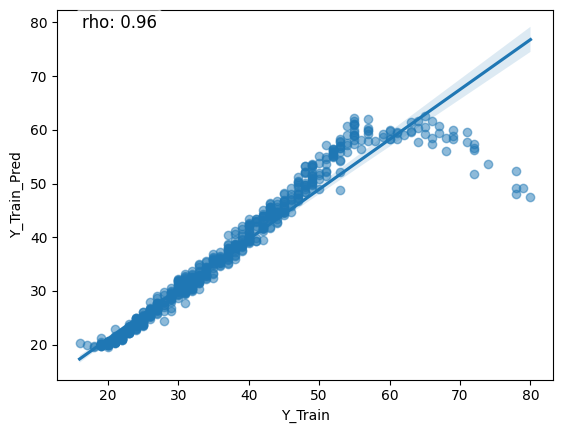

In [18]:
corr, _ = pearsonr(df_train['Y_Train'], df_train['Y_Train_Pred'])
corr_text = f'rho: {corr:.2f}'
sns.regplot(x='Y_Train', y='Y_Train_Pred', data=df_train, scatter_kws={'alpha':0.5})
plt.annotate(corr_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", alpha=0.5, color='w'))
plt.show()

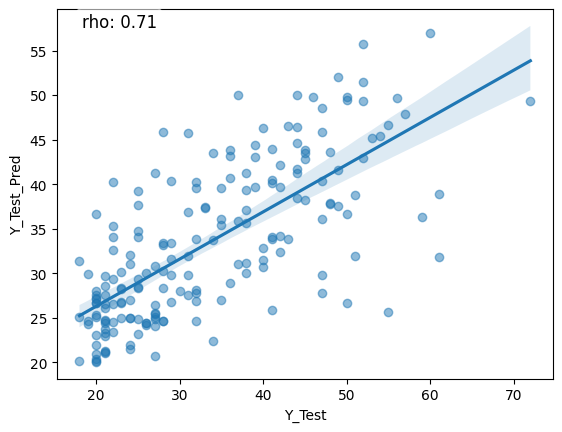

In [19]:
corr, _ = pearsonr(df_test['Y_Test'], df_test['Y_Test_Pred'])
corr_text = f'rho: {corr:.2f}'
sns.regplot(x='Y_Test', y='Y_Test_Pred', data=df_test, scatter_kws={'alpha':0.5})
plt.annotate(corr_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", alpha=0.5, color='w'))
plt.show()

In [20]:

mape_train, r2_train, mape_test, r2_test = compute_age_mae_r2(model, std_train_loader, std_test_loader, device)
print(f"Train Age MAE: {mape_train}, Test Age MAE: {mape_test}.")
print(f"Train Age R2: {r2_train}, Test Age R2: {r2_test}.")

Training age estimator
Train Age MAE: 0.0362284816801548, Test Age MAE: 0.18912148475646973.
Train Age R2: 0.9290240380287226, Test Age R2: 0.5094591768221679.


### Learning Curve

In [21]:
X = np.row_stack((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [30]:
estimator = AgeEstimator()
train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring = 'neg_mean_absolute_percentage_error')

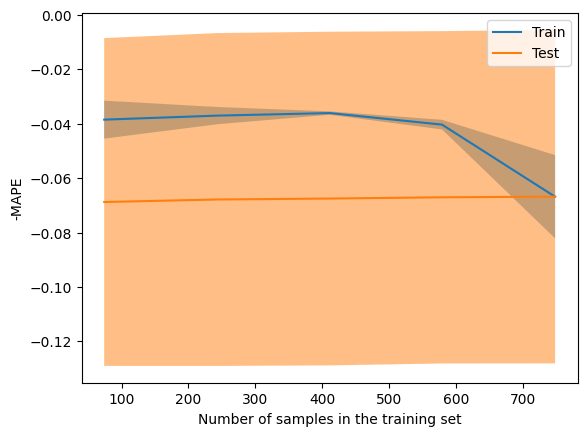

In [31]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="-MAPE")
display.plot()
plt.show()

## Train Embedding

In [24]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat = model(features)
        emb_features.append(out_feat.cpu())
        loss = criterion_pft(out_feat.unsqueeze(1), targets)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   2.58


In [25]:
emb_features = torch.row_stack(emb_features)
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])
emb_features["sub"] = np.arange(1, len(emb_features) +1)

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(-1.2, 1.2)

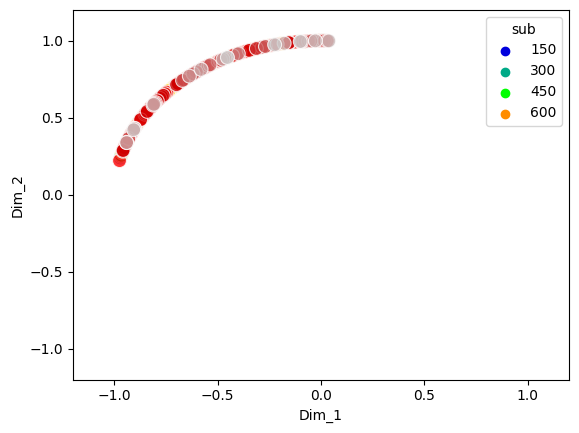

In [26]:
# time to cry
# I probably messed up the original loss. Went over it multiple times

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)


### Test Embedding

In [27]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_test_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat = model(features)
        emb_features.append(out_feat.cpu())
        loss = criterion_pft(out_feat.unsqueeze(1), targets)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   3.68


In [28]:
emb_features = torch.row_stack(emb_features)
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])
emb_features["sub"] = np.arange(1, len(emb_features) +1)


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(-1.2, 1.2)

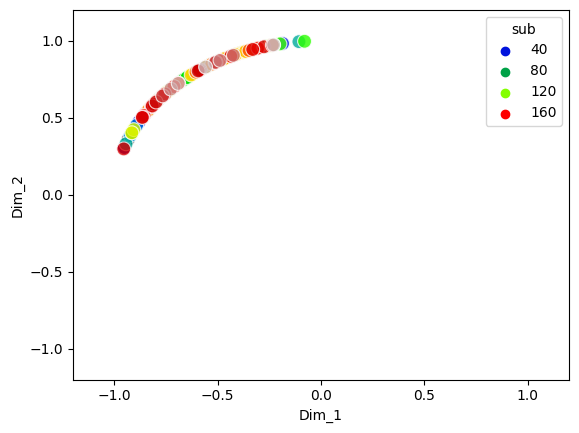

In [29]:
sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)